In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Flatten, Reshape, Lambda, BatchNormalization, ELU
from keras.models import Model
from keras.losses import  binary_crossentropy, mse
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import keras.backend as kb
from keras.datasets import mnist
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

batchSize = 32
codeSize  = 64

Using TensorFlow backend.


In [2]:
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()

imgSize = xTrain.shape[1]

xTrain = np.reshape( xTrain, [-1, imgSize, imgSize, 1])/255
xTest = np.reshape( xTest, [-1, imgSize, imgSize, 1])/255

In [3]:
def plotGrid( data, title ):
    """Plots a grid of images. Assumes that len(data) is a perfect square."""

    m = int(np.sqrt( len(data)) )
    f, axarr = plt.subplots(m, m)
    k = 0

    f.suptitle( title )

    for i in range(m):
        for j in range(m):

            axarr[i,j].imshow( 1 - data[k,:,:,0], vmin = 0, vmax = 1, cmap = "gray" )
            axarr[i,j].get_xaxis().set_ticks([])
            axarr[i,j].get_yaxis().set_ticks([])

            k += 1

    plt.show()

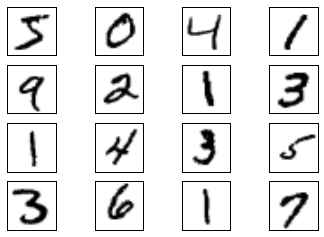

In [4]:
plotGrid( xTrain[:16], "" )

In [5]:
def sampling( args ):
    
    mean, logSigma = args
    batch = kb.shape( mean )[0]
    dim   = kb.int_shape( mean )[1]

    epsilon = kb.random_normal( shape = (batch, dim) )

    return mean + kb.exp(0.5 * logSigma ) * epsilon

In [6]:
inputs = Input( shape = ( imgSize, imgSize, 1,) )

conv1 = ELU()( Conv2D( 16, 3, strides = 1, padding = 'same', data_format = "channels_last", )( inputs ))
pool1 = MaxPooling2D( data_format = "channels_last" )( conv1 )

conv2 = ELU()( Conv2D( 16, 3, strides = 1, padding = 'same', data_format = "channels_last")( pool1 ) )
pool2 = MaxPooling2D( data_format = "channels_last" )( conv2 )

flat  = Flatten()( pool2 )

mean     = Dense( codeSize )( flat )
logSigma = Dense( codeSize )( flat )

encoding = Lambda(sampling, output_shape = ( codeSize,) )( [mean, logSigma] )

decoderInput = Input( shape = (codeSize, ) )

dense = Dense( 16 * 7 * 7 )( decoderInput )

unflatten = Reshape( (7, 7, 16) )( dense )

unpool1 = UpSampling2D( data_format = "channels_last" )( unflatten )
deconv1 = ELU()( Conv2DTranspose( 16, 3, strides = 1, padding = 'same', data_format = "channels_last" )( unpool1 ) )

unpool2 = UpSampling2D( data_format = "channels_last" )( deconv1 )
decoding = Conv2DTranspose( 1, 3, strides = 1, padding = 'same', data_format = "channels_last", activation = "sigmoid" )( unpool2 )

In [7]:
encoder = Model( inputs, [mean, logSigma, encoding], name = 'encoder')
decoder = Model( decoderInput, decoding, name = "decoder")

fullPass = decoder( encoder(inputs)[2] )

VAE = Model( inputs, fullPass, name = 'vae' )

In [8]:
#reconLoss = imgSize * imgSize * binary_crossentropy( kb.flatten( inputs ), kb.flatten( fullPass ) )
reconLoss = imgSize * imgSize * mse( kb.flatten( inputs ), kb.flatten( fullPass ) )
klLoss = -0.5 * kb.sum(1 + logSigma - kb.square(mean) - kb.exp(logSigma), axis = -1 )
loss = kb.mean( reconLoss + klLoss )

opt = Adam() #Adam( lr = 0.0005, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.1, decay = 0.01 )

VAE.add_loss( loss )
VAE.compile( optimizer = opt, loss = None )

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: UserWarning: Output "decoder" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder" during training.
  if __name__ == '__main__':


In [9]:
earlyStoper  = EarlyStopping( patience = 10, verbose = 1 )
checkPointer = ModelCheckpoint( filepath = "weights/mnist.hdf5", verbose = 1, save_best_only=True )

VAE.fit( xTrain, None,
         validation_data = ( xTest, None),
         epochs = 5000,
         batch_size = batchSize,
         callbacks = [ earlyStoper, checkPointer ] )

Train on 60000 samples, validate on 10000 samples
Epoch 1/5000
59968/60000 [============================>.] - ETA: 0s - loss: 41.6975
Epoch 00001: val_loss improved from inf to 34.29155, saving model to weights/mnist.hdf5
60000/60000 [==============================] - 10s 175us/step - loss: 41.6942 - val_loss: 34.2915
Epoch 2/5000
59968/60000 [============================>.] - ETA: 0s - loss: 33.5545
Epoch 00002: val_loss improved from 34.29155 to 32.48702, saving model to weights/mnist.hdf5
60000/60000 [==============================] - 9s 155us/step - loss: 33.5548 - val_loss: 32.4870
Epoch 3/5000
59872/60000 [============================>.] - ETA: 0s - loss: 32.4563
Epoch 00003: val_loss improved from 32.48702 to 31.75992, saving model to weights/mnist.hdf5
60000/60000 [==============================] - 9s 156us/step - loss: 32.4541 - val_loss: 31.7599
Epoch 4/5000
59680/60000 [============================>.] - ETA: 0s - loss: 31.9486
Epoch 00004: val_loss improved from 31.75992 to 

Epoch 34/5000
59712/60000 [============================>.] - ETA: 0s - loss: 30.0087
Epoch 00034: val_loss did not improve
60000/60000 [==============================] - 9s 150us/step - loss: 30.0094 - val_loss: 29.8792
Epoch 35/5000
59840/60000 [============================>.] - ETA: 0s - loss: 29.9860
Epoch 00035: val_loss did not improve
60000/60000 [==============================] - 9s 152us/step - loss: 29.9835 - val_loss: 29.7655
Epoch 36/5000
59744/60000 [============================>.] - ETA: 0s - loss: 30.0007
Epoch 00036: val_loss improved from 29.67766 to 29.65689, saving model to weights/mnist.hdf5
60000/60000 [==============================] - 9s 155us/step - loss: 30.0031 - val_loss: 29.6569
Epoch 37/5000
59936/60000 [============================>.] - ETA: 0s - loss: 29.9940
Epoch 00037: val_loss did not improve
60000/60000 [==============================] - 9s 154us/step - loss: 29.9921 - val_loss: 29.7698
Epoch 38/5000
59936/60000 [============================>.] - ETA:

## Test the last iteration of training

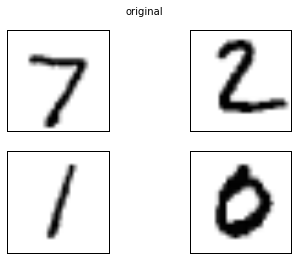

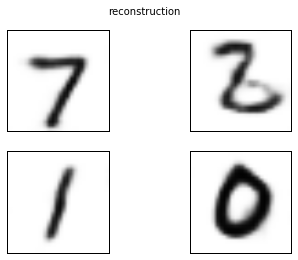

In [10]:
recon = VAE.predict( xTest[:4] )

plotGrid( xTest[:4], "original" )
plotGrid( recon, "reconstruction" )

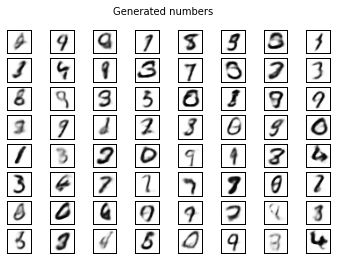

In [11]:
codes = np.random.normal( size = (64, codeSize) )
numbers = decoder.predict( codes )

plotGrid( numbers, "Generated numbers" )

## Best model

In [12]:
VAE.load_weights( "weights/mnist.hdf5" )

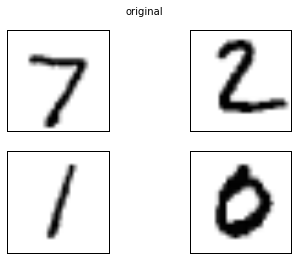

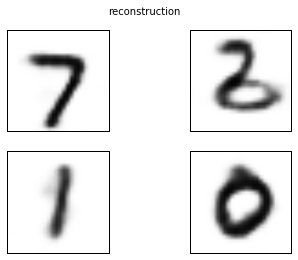

In [13]:
recon = VAE.predict( xTest[:4] )

plotGrid( xTest[:4], "original" )
plotGrid( recon, "reconstruction" )

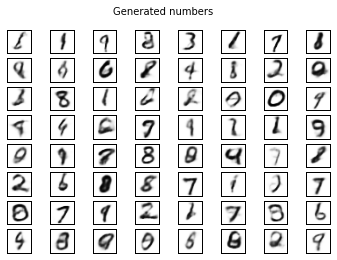

In [14]:
codes = np.random.normal( size = (64, codeSize) )
numbers = decoder.predict( codes )

plotGrid( numbers, "Generated numbers" )